In [1]:
import importlib

import mesh2d
import boundary
import animation
import parameters

importlib.reload(mesh2d)
importlib.reload(animation)

import os
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
from IPython.display import HTML

import math

%matplotlib inline

In [2]:
km = parameters.km
kp = parameters.kp
conc_rac = parameters.conc_rac
conc_gfp = parameters.conc_gfp

print("km:", km)
print("kp:", kp)
print("conc_rac:", conc_rac)
print("conc_gfp:", conc_gfp)

km: 0.23000000000000007
kp: 11.839878157810809
conc_rac: 1.111111111111111
conc_gfp: 1.0


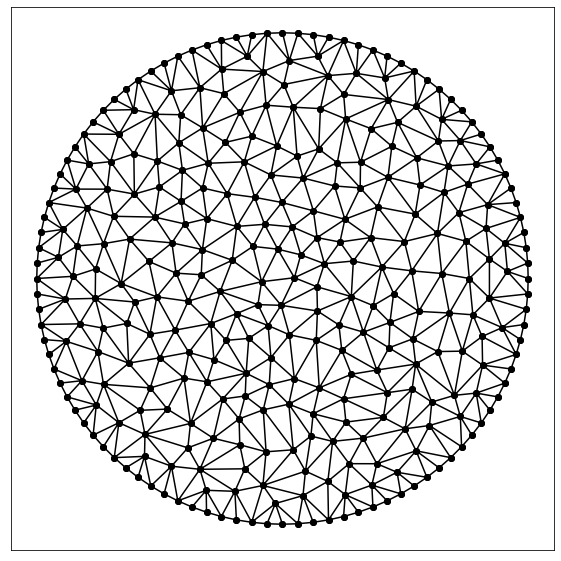

In [3]:
# Create mesh
n_boundary = 100
min_area = 0.01
mesh = mesh2d.Mesh2D(n_boundary, min_size=min_area, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Heat Equation with von Neumann Coupled Boundary

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u$
- von Neumann coupled to kinetics: $\partial_n u(x,y) = -\dot{u_b}$
- Kinetic equation: $\dot{u_b} = k_+ u (r_0 - u_b) - k_- u_b$
- Initial state: $u=1$
- Rac activation: 10% around entire cell

### Analytical solution

In [4]:
ACTIVE_RAC = 2e-1
a = 2.0
r0 = conc_rac*ACTIVE_RAC
b = -(1.0 + 2.0*r0 + km/kp)
c = r0
# print(a, b, c)
u_b0 = (-b - math.sqrt(b**2 - 4.0*a*c))/(2.0*a)
print("Bound GFP:", u_b0)
u_0 = 1.0 - 2.0*u_b0
print("Free GFP:", u_0)

Bound GFP: 0.21490084473776652
Free GFP: 0.570198310524467


### Numerical Solution

In [5]:
def calculate_initial_condition(vertex):
    return conc_gfp

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def generate_boundary_values(boundary, u):
    return -1*boundary.calc_ddt(u)

def print_integration(u, ub):
    print("Total GFP: ", mesh.integrate(u) + mesh.integrate_around_edge(ub.bound_gfp))
    print("Cytoplasma: ", mesh.integrate(u))
    print("Boundary: ", mesh.integrate_around_edge(ub.bound_gfp))
    
def print_change(u0, u, ub):
    total_before = mesh.integrate(u0)
    total_after = mesh.integrate(u) + mesh.integrate_around_edge(ub.bound_gfp)
    print("Change in total GFP:", total_after - total_before)

In [6]:
def run_simulation(mesh, membrane, total_time=1.0, steps_per_time=50):
    # Work out timings
    total_steps = int(total_time*steps_per_time)
    T = total_time/parameters.T0
    dt = T/total_steps
#     print("dt:", dt)
    t = 0.0

    # Initial conditions
    u_prev = set_initial_conditions(mesh)

    # Assemble matrices
    stiffness = mesh.assemble_stiffness()
    mass = mesh.assemble_mass()

    # Form LHS matrix
    lhs_matrix = dt*stiffness + mass

    # For animating
    anim = animation.Animation(mesh, (15, 5))

    while t<T:
        # Calculate boundary condition
        boundary_values = generate_boundary_values(membrane, u_prev)
        boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

        # Solve FEM PDE
        rhs_vector = dt*boundary_vector + mass.dot(u_prev)
        u_next = np.linalg.solve(lhs_matrix, rhs_vector)

        # Update boundary ODE
        membrane.update(dt)

        # Add solution to animation
        anim.add_frame(u_prev, membrane.bound_gfp/parameters.membrane_thickness)

        # Advance timestep
        u_prev[:] = u_next[:]
        t+=dt
    
    return anim

# Changing apparent membrane thickness

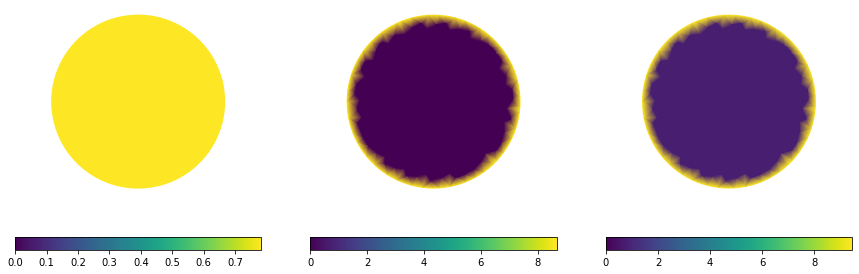

membrane thickness: 0.25


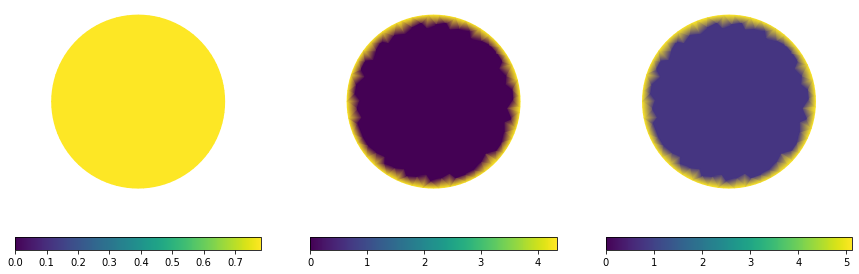

membrane thickness: 0.5


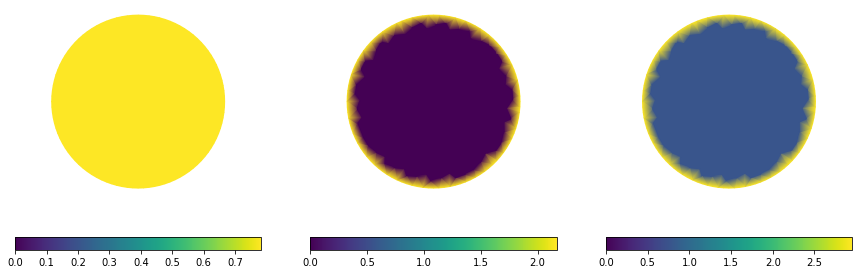

membrane thickness: 1


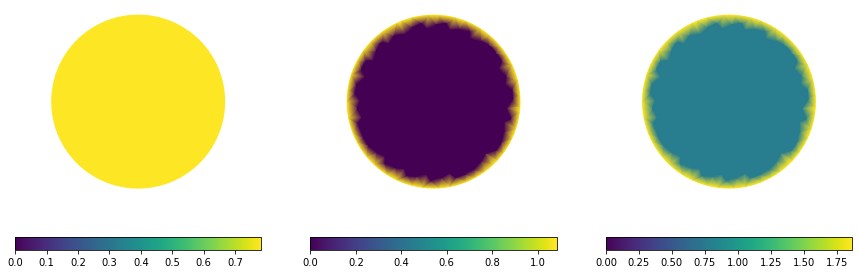

membrane thickness: 2


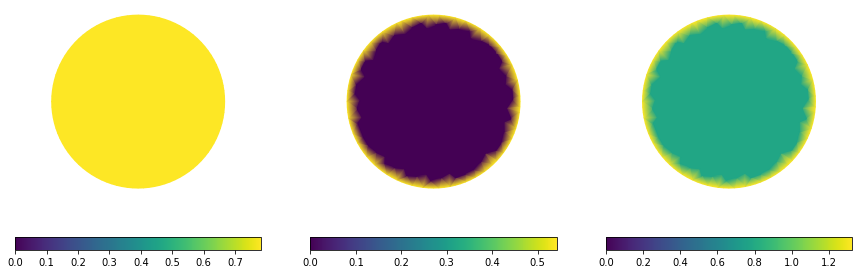

membrane thickness: 4


In [7]:
# Set active Rac
# for index in mesh.boundary_vertices:
#     theta = theta_from_vertex(mesh.get_pos(index))
#     if theta > 0:
#         boundary.active_rac[index] = conc_rac*1e-2*np.sin(theta)
#     else:
#         boundary.active_rac[index] = -conc_rac*2e-2*np.sin(theta)

n_boundary_points=100
min_area=0.01

# Create mesh
mesh = mesh2d.Mesh2D(n_boundary_points, min_size=min_area, min_angle=22)
membrane = boundary.Boundary(mesh.n_vertices, mesh.boundary_vertices, km, kp)
active_rac=0.1
original_thickness = parameters.membrane_thickness

for factor in [1/4, 1/2, 1, 2, 4]:
    parameters.membrane_thickness = original_thickness*factor
    membrane.reset()
    membrane.set_active_rac(conc_rac*active_rac)
    anim = run_simulation(mesh, membrane, total_time=3.0, steps_per_time=50)

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    mesh.plot_triple(anim.solutions[-1], anim.boundary_solutions[-1], axes, vmin=0.0)
    plt.show()
    
    print("membrane thickness:", factor)
#     print_integration(anim.solutions[-1], membrane)
    
    path = "./uniform/"+str(active_rac)
    try:
        os.makedirs(path)
    except FileExistsError:
        pass

# Uniform Active Rac

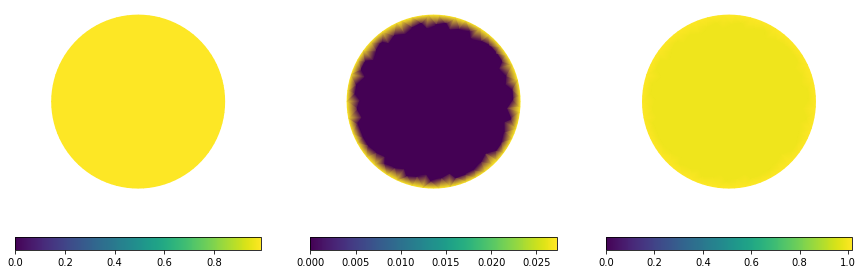

Active Rac:  0.005
Total GFP:  3.139526024734473
Cytoplasma:  3.1052980738672917
Boundary:  0.0342279508671813


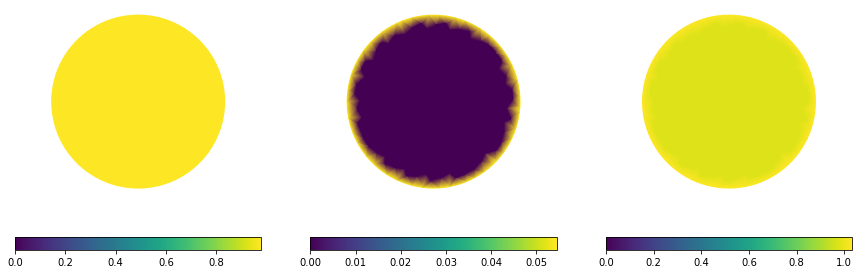

Active Rac:  0.01
Total GFP:  3.1395260850576747
Cytoplasma:  3.071085048730568
Boundary:  0.06844103632710648


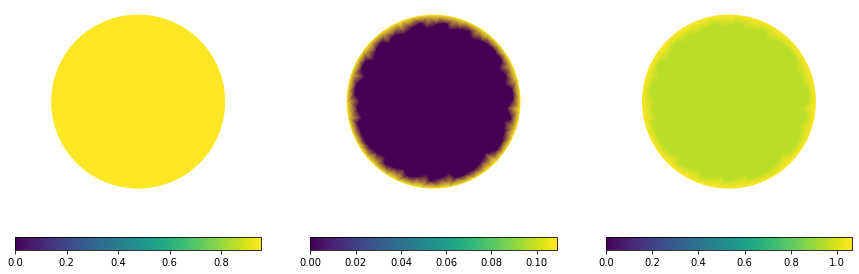

Active Rac:  0.02
Total GFP:  3.1395262505695536
Cytoplasma:  3.0027057123582583
Boundary:  0.13682053821129544


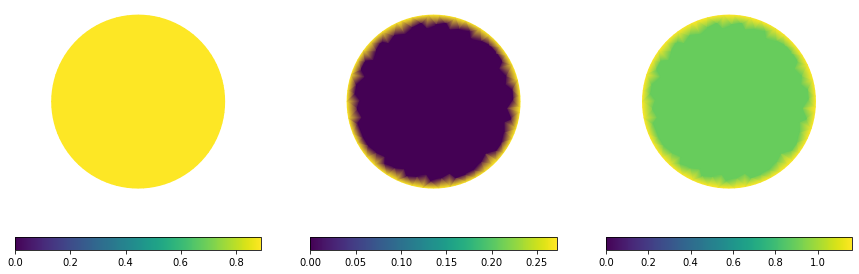

Active Rac:  0.05
Total GFP:  3.1395273272686257
Cytoplasma:  2.7979841963671412
Boundary:  0.3415431309014846


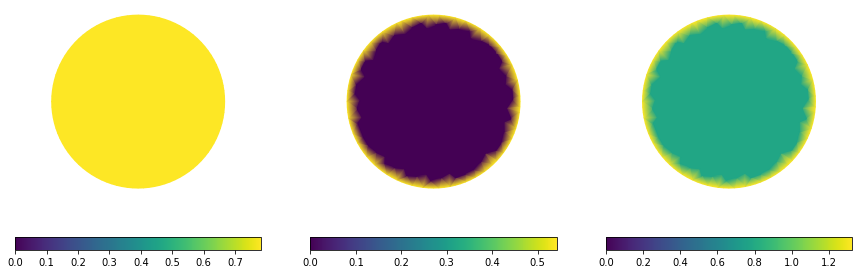

Active Rac:  0.1
Total GFP:  3.139533830131899
Cytoplasma:  2.458548215516038
Boundary:  0.6809856146158609


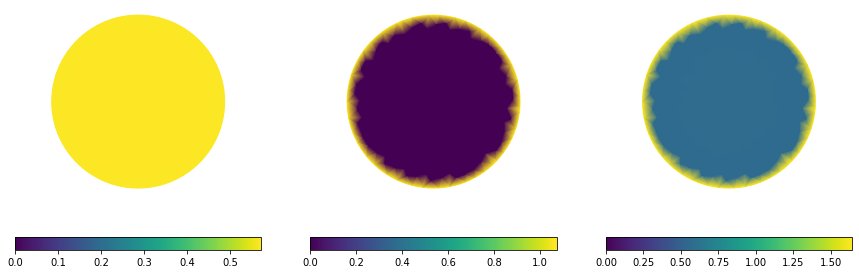

Active Rac:  0.2
Total GFP:  3.1396269940067283
Cytoplasma:  1.791972537472749
Boundary:  1.3476544565339794


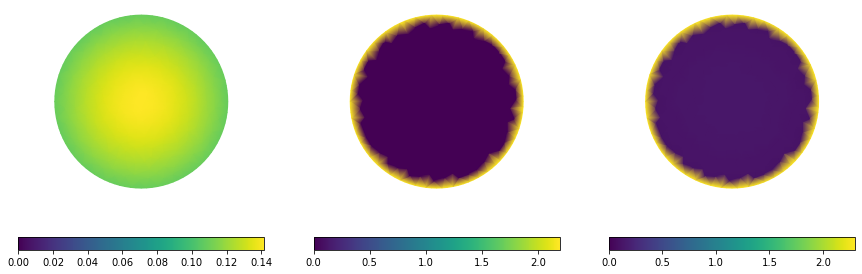

Active Rac:  0.5
Total GFP:  3.1414574516187734
Cytoplasma:  0.3899837335355236
Boundary:  2.75147371808325


In [8]:
# Set active Rac
# for index in mesh.boundary_vertices:
#     theta = theta_from_vertex(mesh.get_pos(index))
#     if theta > 0:
#         boundary.active_rac[index] = conc_rac*1e-2*np.sin(theta)
#     else:
#         boundary.active_rac[index] = -conc_rac*2e-2*np.sin(theta)

n_boundary_points=100
min_area=0.01

# Create mesh
mesh = mesh2d.Mesh2D(n_boundary_points, min_size=min_area, min_angle=22)
membrane = boundary.Boundary(mesh.n_vertices, mesh.boundary_vertices, km, kp)

for active_rac in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    membrane.reset()
    membrane.set_active_rac(conc_rac*active_rac)
    anim = run_simulation(mesh, membrane, total_time=3.0, steps_per_time=50)

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    mesh.plot_triple(anim.solutions[-1], anim.boundary_solutions[-1], axes, vmin=0.0)
    plt.show()
    
    print("Active Rac: ", active_rac)
    print_integration(anim.solutions[-1], membrane)
    
    path = "./uniform/"+str(active_rac)
    try:
        os.makedirs(path)
    except FileExistsError:
        pass
#     anim.save_frames(path+"/dump", frames=[-1], is_triple=True, fix_colourbar=True)

# Sin profile

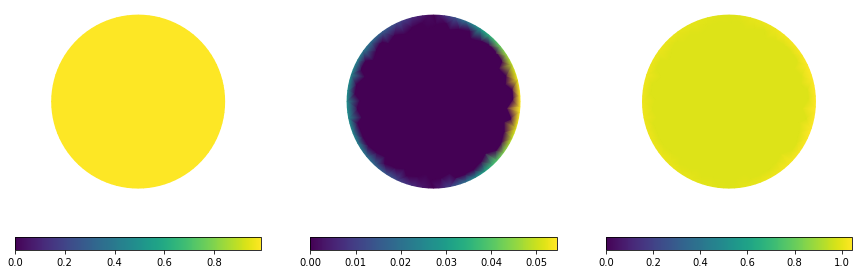

Active Rac:  0.005 0.01
Total GFP:  3.1395260259046545
Cytoplasma:  3.1068513138171343
Boundary:  0.03267471208752015


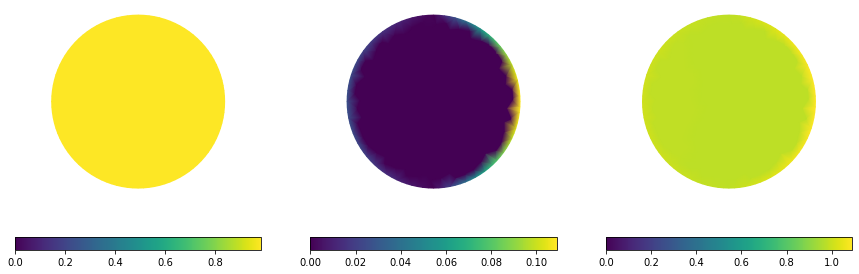

Active Rac:  0.005 0.02
Total GFP:  3.1395260874946636
Cytoplasma:  3.0850766867701154
Boundary:  0.054449400724548326


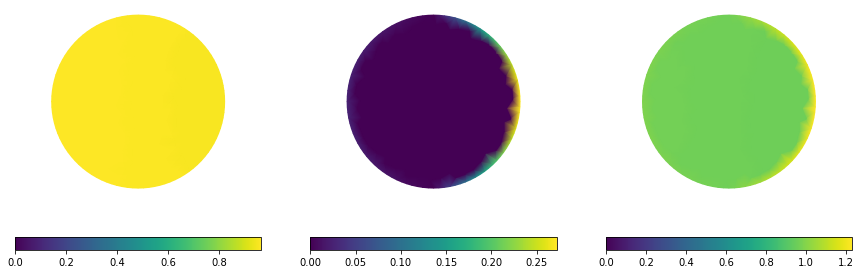

Active Rac:  0.005 0.05
Total GFP:  3.1395264843676434
Cytoplasma:  3.0197976998310616
Boundary:  0.11972878453658159


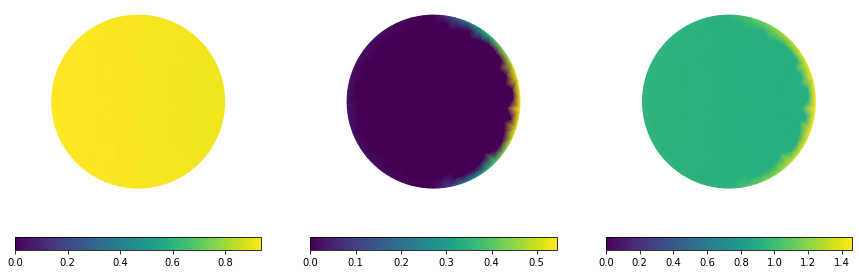

Active Rac:  0.005 0.1
Total GFP:  3.1395281643642705
Cytoplasma:  2.9111663242547015
Boundary:  0.22836184010956914


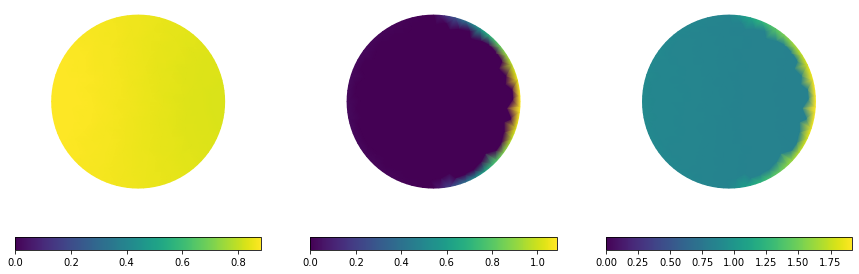

Active Rac:  0.005 0.2
Total GFP:  3.1395397911631284
Cytoplasma:  2.6947251890421993
Boundary:  0.444814602120929


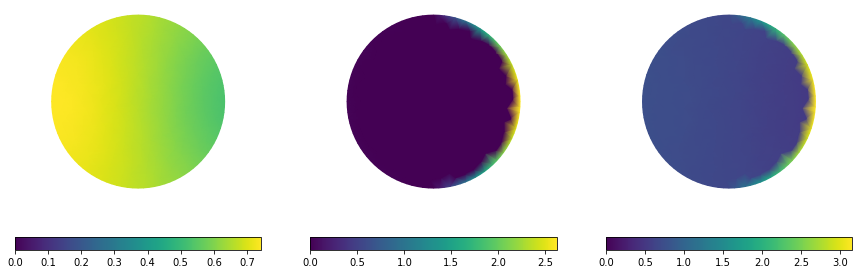

Active Rac:  0.005 0.5
Total GFP:  3.1400356901942406
Cytoplasma:  2.0675838488101626
Boundary:  1.0724518413840778


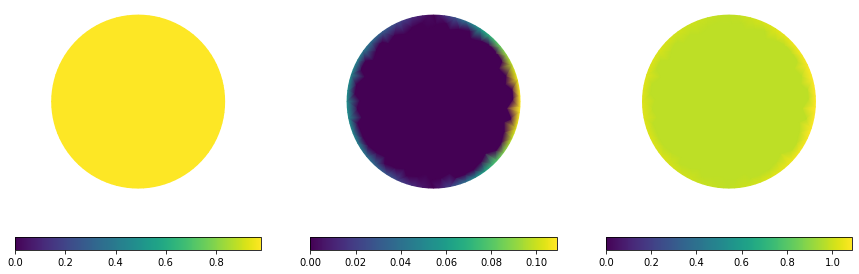

Active Rac:  0.01 0.02
Total GFP:  3.1395260944264383
Cytoplasma:  3.07419049994596
Boundary:  0.0653355944804783


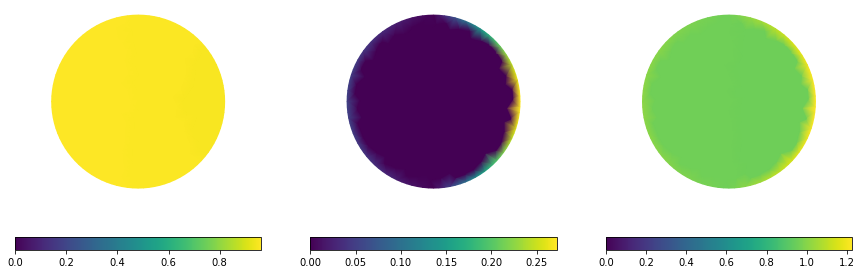

Active Rac:  0.01 0.05
Total GFP:  3.1395264653746344
Cytoplasma:  3.0089194718568466
Boundary:  0.13060699351778793


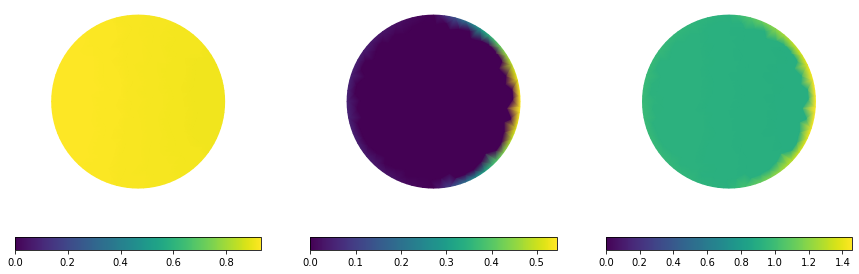

Active Rac:  0.01 0.1
Total GFP:  3.139528103103738
Cytoplasma:  2.900302608047129
Boundary:  0.2392254950566088


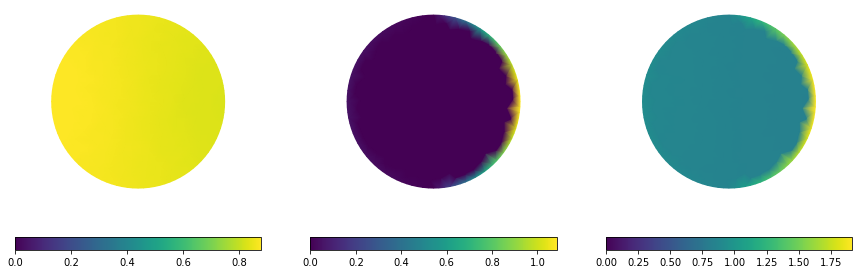

Active Rac:  0.01 0.2
Total GFP:  3.139539684219499
Cytoplasma:  2.683897103757147
Boundary:  0.4556425804623521


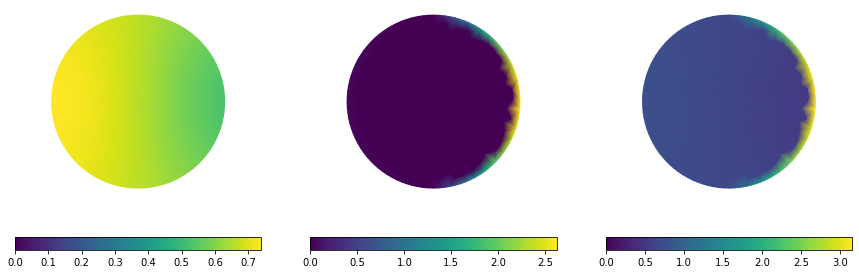

Active Rac:  0.01 0.5
Total GFP:  3.140037907563195
Cytoplasma:  2.057080376930764
Boundary:  1.082957530632431


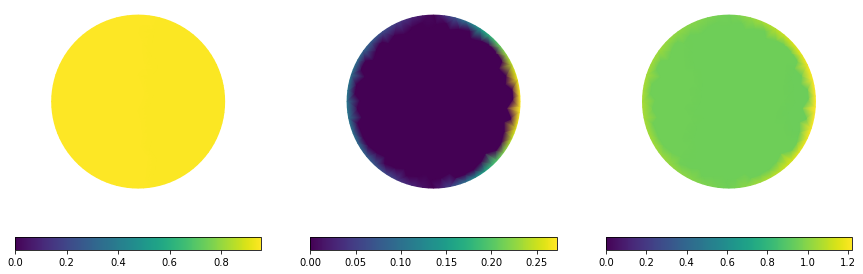

Active Rac:  0.02 0.05
Total GFP:  3.1395264488539443
Cytoplasma:  2.9871687169053684
Boundary:  0.15235773194857594


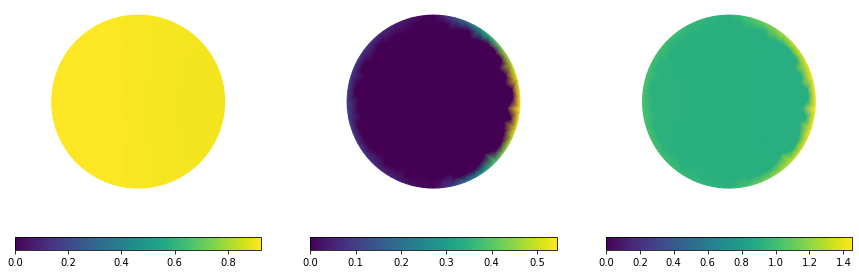

Active Rac:  0.02 0.1
Total GFP:  3.13952800084592
Cytoplasma:  2.8785813213746687
Boundary:  0.2609466794712515


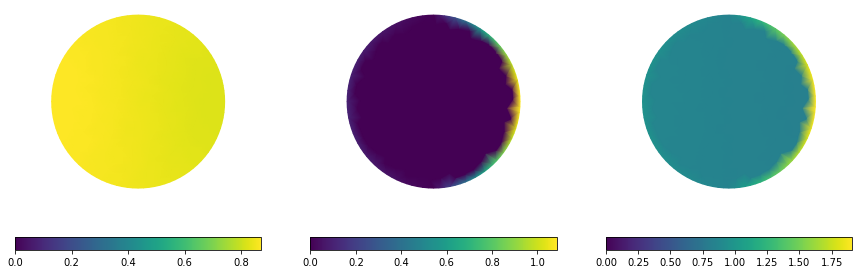

Active Rac:  0.02 0.2
Total GFP:  3.139539487157832
Cytoplasma:  2.662248156624234
Boundary:  0.4772913305335978


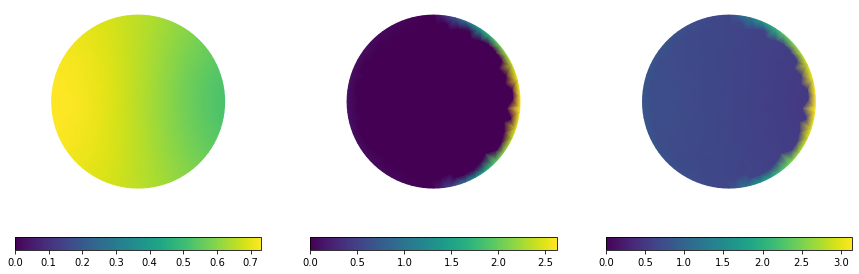

Active Rac:  0.02 0.5
Total GFP:  3.140042285227194
Cytoplasma:  2.0360887693356755
Boundary:  1.1039535158915188


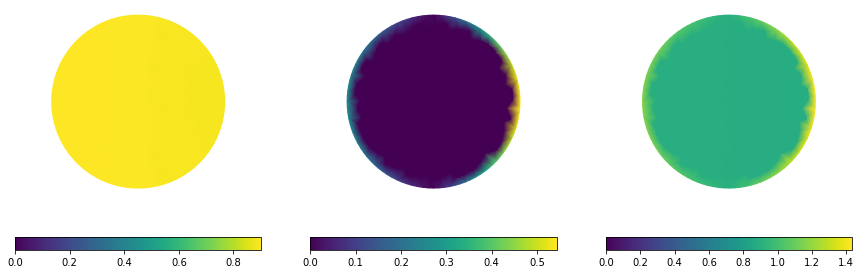

Active Rac:  0.05 0.1
Total GFP:  3.1395278940758127
Cytoplasma:  2.813469190679073
Boundary:  0.3260587033967398


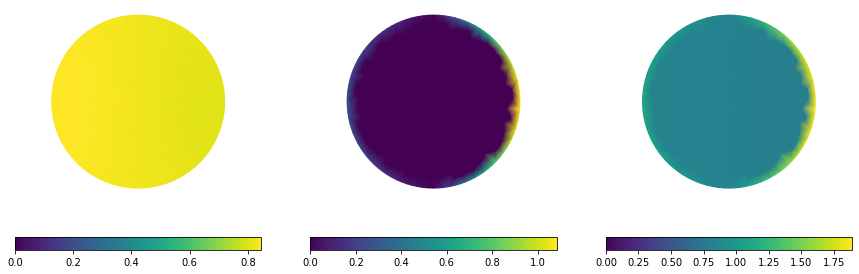

Active Rac:  0.05 0.2
Total GFP:  3.1395390708585795
Cytoplasma:  2.5973621279315737
Boundary:  0.5421769429270059


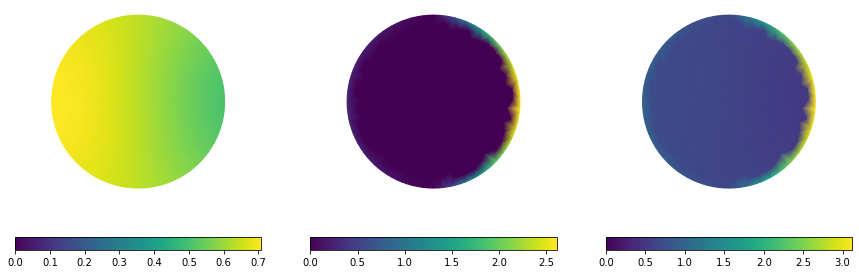

Active Rac:  0.05 0.5
Total GFP:  3.1400549502604487
Cytoplasma:  1.9732404385830766
Boundary:  1.166814511677372


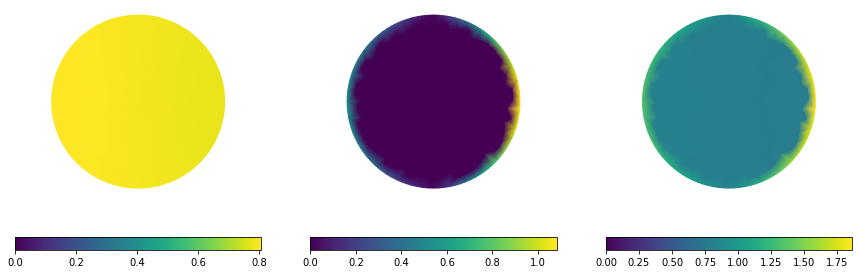

Active Rac:  0.1 0.2
Total GFP:  3.139539341993805
Cytoplasma:  2.4894457244897152
Boundary:  0.6500936175040897


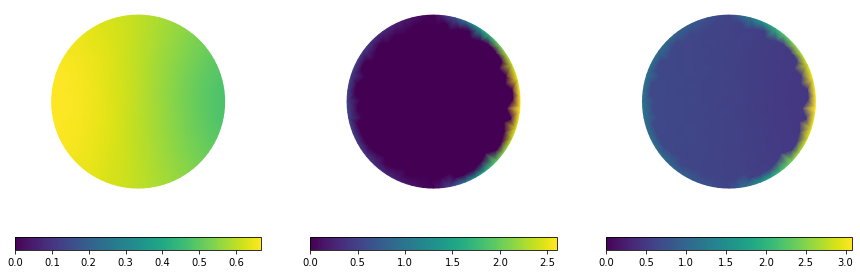

Active Rac:  0.1 0.5
Total GFP:  3.140074572008124
Cytoplasma:  1.8689451492550033
Boundary:  1.2711294227531207


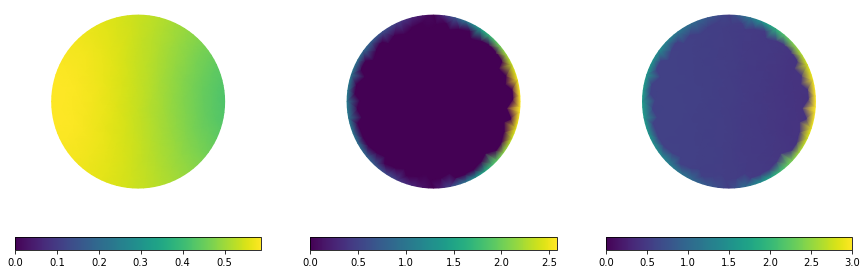

Active Rac:  0.2 0.5
Total GFP:  3.1401126518064073
Cytoplasma:  1.6624128594023269
Boundary:  1.4776997924040804


In [9]:
# Set active Rac
def set_active_rac(mesh, membrane, level1, level2):
    rac = np.zeros(mesh.n_vertices)
    for index in mesh.boundary_vertices:
        theta = theta_from_vertex(mesh.get_pos(index))
        if abs(theta) > np.pi/2:
            rac[index] = conc_rac*level1*abs(np.sin(theta+np.pi/2))
        else:
            rac[index] = conc_rac*level2*abs(np.sin(theta+np.pi/2))
    membrane.set_active_rac(rac)

n_boundary_points=100
min_area=0.01

# Create mesh
mesh = mesh2d.Mesh2D(n_boundary_points, min_size=min_area, min_angle=22)
membrane = boundary.Boundary(mesh.n_vertices, mesh.boundary_vertices, km, kp)

rac_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

for i, active_rac1 in enumerate(rac_levels[:-1]):
    for active_rac2 in rac_levels[i+1:]:
        membrane.reset()
        set_active_rac(mesh, membrane, active_rac1, active_rac2)
        anim = run_simulation(mesh, membrane, total_time=3.0, steps_per_time=50)

        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        mesh.plot_triple(anim.solutions[-1], anim.boundary_solutions[-1], axes, vmin=0.0)
        plt.show()

        print("Active Rac: ", active_rac1, active_rac2)
        print_integration(anim.solutions[-1], membrane)

        path = "./uniform/"+str(active_rac)
        try:
            os.makedirs(path)
        except FileExistsError:
            pass
    #     anim.save_frames(path+"/dump", frames=[-1], is_triple=True, fix_colourbar=True)

# Half sin profile

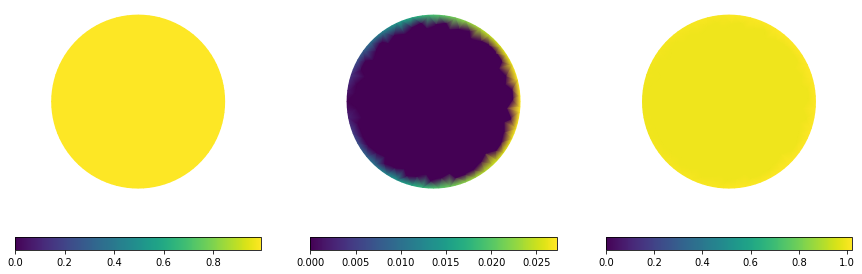

Active Rac:  0.005
Total GFP:  3.1395260078983616
Cytoplasma:  3.1177360048992355
Boundary:  0.021790002999126232


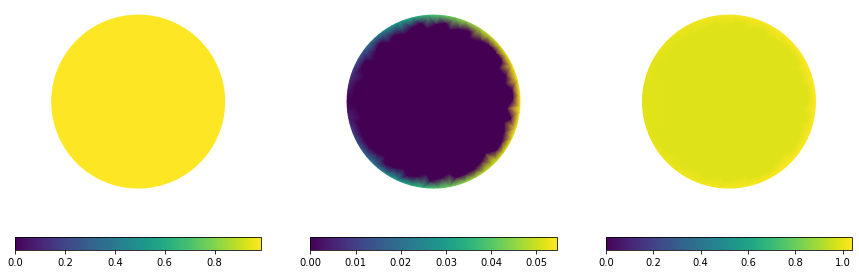

Active Rac:  0.01
Total GFP:  3.1395260481883516
Cytoplasma:  3.095952178874418
Boundary:  0.04357386931393367


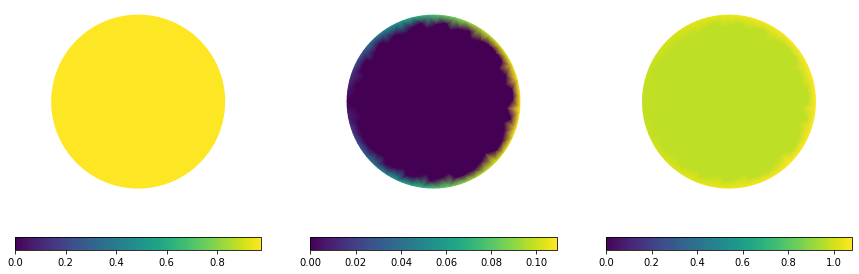

Active Rac:  0.02
Total GFP:  3.139526159134897
Cytoplasma:  3.052403545660135
Boundary:  0.0871226134747619


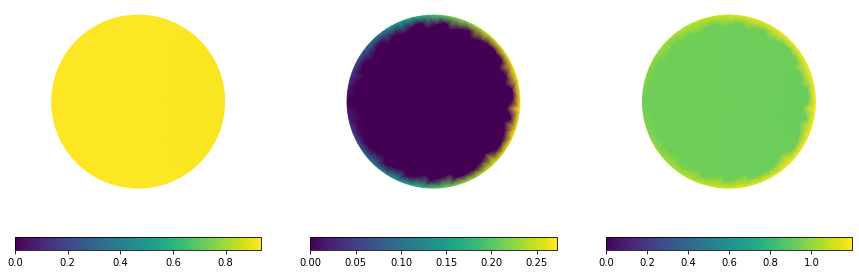

Active Rac:  0.05
Total GFP:  3.1395268218921055
Cytoplasma:  2.9219213561924122
Boundary:  0.21760546569969336


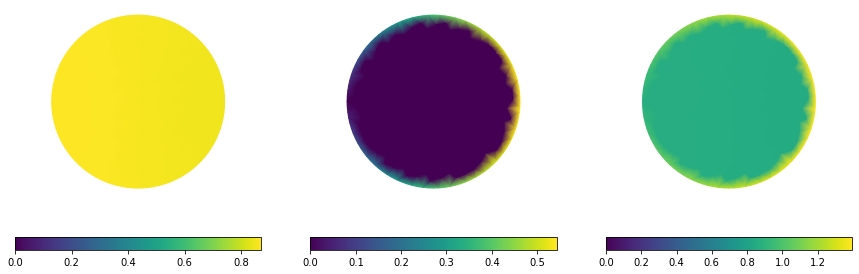

Active Rac:  0.1
Total GFP:  3.1395299456686043
Cytoplasma:  2.705091486838414
Boundary:  0.4344384588301902


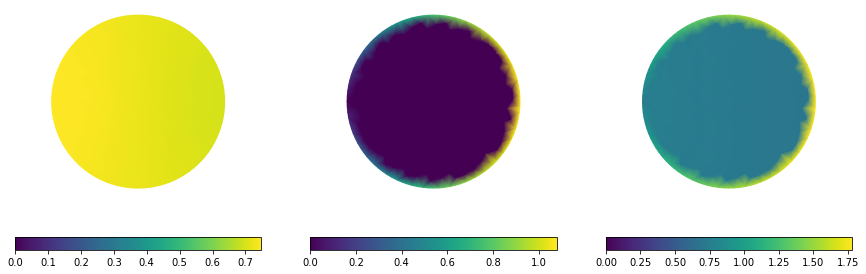

Active Rac:  0.2
Total GFP:  3.139560629504012
Cytoplasma:  2.275011709112642
Boundary:  0.8645489203913697


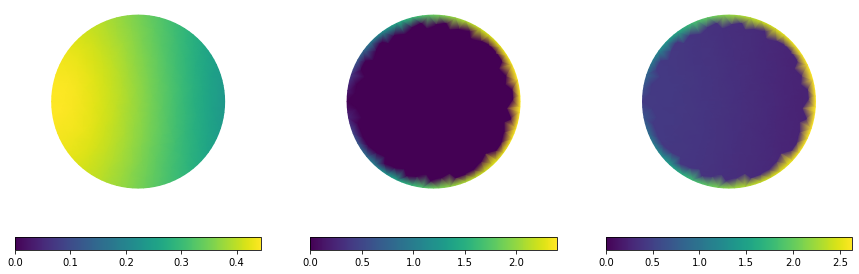

Active Rac:  0.5
Total GFP:  3.1409908890574223
Cytoplasma:  1.1248070802432166
Boundary:  2.0161838088142057


In [10]:
# Set active Rac
def set_active_rac(mesh, membrane, level):
    rac = np.zeros(mesh.n_vertices)
    for index in mesh.boundary_vertices:
        theta = theta_from_vertex(mesh.get_pos(index)) + np.pi
        rac[index] = conc_rac*level*np.sin(0.5*theta)
    membrane.set_active_rac(rac)

n_boundary_points=100
min_area=0.01

# Create mesh
mesh = mesh2d.Mesh2D(n_boundary_points, min_size=min_area, min_angle=22)
membrane = boundary.Boundary(mesh.n_vertices, mesh.boundary_vertices, km, kp)

rac_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

for active_rac in rac_levels:
    membrane.reset()
    set_active_rac(mesh, membrane, active_rac)
    anim = run_simulation(mesh, membrane, total_time=3.0, steps_per_time=50)

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    mesh.plot_triple(anim.solutions[-1], anim.boundary_solutions[-1], axes, vmin=0.0)
    plt.show()

    print("Active Rac: ", active_rac)
    print_integration(anim.solutions[-1], membrane)

    path = "./uniform/"+str(active_rac)
    try:
        os.makedirs(path)
    except FileExistsError:
        pass
#     anim.save_frames(path+"/dump", frames=[-1], is_triple=True, fix_colourbar=True)